In [1]:
import sys, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from core.dataprovider import DataProvider
from core.datachecker import DataChecker
from core.datavisualizer import DataVisualizer
from core.flowsolver import FlowSolver

# Path configuration
MainPath = os.path.join('.')
sys.path.insert(0, MainPath)
sys.path.insert(0, os.path.join(os.getcwd(), '.', 'lib', 'odym', 'modules'))

# ODYM classes
import ODYM_Classes as msc

# For Ipython Notebook only
%matplotlib inline


# **********************************************
# * Step 1: Define parameters for the aiphoria *
# **********************************************
model_params = {
    # Path (either relative or absolute) to the Excel file that contains the data for Processes and Flows
    # Path to the Excel file that contains data for the Processes and Flows
    # Path can be either:
    #   relative path (e.g. "/data/data.xlsx") or
    #   absolute path (e.g. "C:\aiphoria\data\data.xlsx")
    "filename": "data/example_data.xlsx",


    # *************
    # * Processes *
    # *************
    # Name of the sheet in Excel file that contains data for Processes
    "sheet_name_processes": "Processes",

    # Column range that contains data for the Processes
    # The both starting and ending columns are included in the range
    # (e.g. "A:B" means columns A, B, and C)
    "column_range_processes": "B:R",

    # Number of rows to skip when reading sheet for Process data
    # Header line must be the first line read (in this case row 3 would contain the header)
    "skip_num_rows_processes": 2,


    # *********
    # * Flows *
    # *********
    # Name of the sheet in Excel file that contains data for Flows
    "sheet_name_flows": "Flows",

    # Column range that contains data for the Flows
    # Only the starting column is included in the range, not the ending column!
    # (e.g. "A:C" means columns A and B)
    "column_range_flows": "B:U",

    # Number of rows to skip when reading sheet for Flow data
    # Header line must be the first line read (in this case row 3 would contain the header)
    "skip_num_rows_flows": 2,


    # ********************
    # * Model parameters *
    # ********************
    # Starting year of the model, this needs to be found from the Excel file
    "year_start": 2021,

    # Ending year of the model, this can be extended as far as needed
    # The last existing year data is copied to the non-existing years
    # Last year is included in the time range
    "year_end": 2030,

    # Should the model detect year range automatically from file?
    # True overrides year_start and year_end values
    "detect_year_range": False,


    # *****************
    # * Virtual flows *
    # *****************
    # Create virtual Processes and Flows
    # Creates missing flows for Processes that have imbalance of input and output flows
    # i.e. unreported flows
    "use_virtual_flows": False,

    # If "use_virtual_flows" is enabled, create virtual flows if
    # absolute difference of process inflows and outflows are
    # greater than this value.
    "virtual_flows_epsilon": 0.1,


    # ********************
    # * Other parameters *
    # ********************
    # Conversion factor from C to CO2
    "conversion_factor_c_to_co2": 3.67,
}

# *********************************************************************************
# * Step 2: Load the data from Excel file using model_parameters and DataProvider *
# *********************************************************************************
print("DataProvider: Reading data from file '{}'...".format(model_params["filename"]))
dataprovider = DataProvider(model_params)

# **********************************************************
# * Step 3: Check data integrity and build flow graph data *
# **********************************************************
print("Checking data integrity, detecting year range from file: {}".format(model_params["detect_year_range"]))
checker = DataChecker(dataprovider)
default_detect_year_range = model_params["detect_year_range"]
flowsolver_data = checker.build_flowsolver_data(model_params["year_start"], model_params["year_end"], detect_year_range=default_detect_year_range)
is_checker_ok, checker_messages = checker.check_for_errors()

# Something went wrong with DataChecker, show error messages and stop execution
if not is_checker_ok:
    for msg in checker_messages:
        print(msg)
    SystemExit(-1)

# Get the updated years from graph_data
years = flowsolver_data["years"]
print("Using year range {} - {}".format(min(years), max(years)))

# *******************************************************************
# * Step 4: Solve flows for all timesteps using aiphoria FlowSolver *
# *******************************************************************
flowsolver = FlowSolver(data=flowsolver_data, use_virtual_flows=model_params["use_virtual_flows"], virtual_flows_epsilon=model_params["virtual_flows_epsilon"])
flowsolver.solve_timesteps()

DataProvider: Reading data from file 'data/example_data.xlsx'...
Checking data integrity, detecting year range from file: False
Checking stock distribution types...
Checking stock distribution parameters...
Checking process total inflows and total outflows mismatches...
Using year range 2021 - 2030


In [2]:
# ***************************
# * Step 5: Initialize ODYM *
# ***************************

# Track solid wood equivalent and carbon. Dictionary of classifications enters the index table defined for the system. The index table lists all aspects needed and assigns a classification and index letter to each aspect.
model_classifications = {
    'Time': msc.Classification(Name='Time', Dimension='Time', ID=1, Items=years),
    'Element': msc.Classification(Name='Elements', Dimension='Element', ID=2, Items=['Solid wood equivalent', 'Carbon']),
}


# Get model time start, end, and duration:
model_time_start = int(min(model_classifications['Time'].Items))
model_time_end = int(max(model_classifications['Time'].Items))
model_duration = model_time_end - model_time_start

index_table = pd.DataFrame({'Aspect': ['Time', 'Element'],  # 'Time' and 'Element' must be present!
                            'Description': ['Model aspect "time"', 'Model aspect "Element"'],
                            'Dimension': ['Time', 'Element'],  # 'Time' and 'Element' are also dimensions
                            'Classification': [model_classifications[Aspect] for Aspect in ['Time', 'Element']],
                            'IndexLetter': ['t', 'e' ]})  # Unique one letter (upper or lower case) indices to be used later for calculations.

index_table.set_index('Aspect', inplace=True)  # Default indexing of IndexTable, other indices are produced on the fly
index_table

,Description,Dimension,Classification,IndexLetter
Aspect,,,,
Time,"Model aspect ""time""",Time,<ODYM_Classes.Classification object at 0x00000...,t
Element,"Model aspect ""Element""",Element,<ODYM_Classes.Classification object at 0x00000...,e


In [3]:
# **************************************
# * Step 6: Initialize ODYM MFA system *
# **************************************
mfa_system = msc.MFAsystem(Name='Wood product system', Geogr_Scope='Europe', Unit='Mm3',
                           ProcessList=[], FlowDict={}, StockDict={}, ParameterDict={},
                           Time_Start=model_time_start, Time_End=model_time_end, IndexTable=index_table,
                           Elements=index_table.loc['Element'].Classification.Items)

# Get inflow values to stock
year_index_to_year = dict(enumerate(years))
unique_processes = flowsolver.get_unique_processes()
unique_flows = flowsolver.get_unique_flows()

# DataFrames for Processes, Flows and Flow values
df_processes = flowsolver.get_processes_as_dataframe()
df_flows = flowsolver.get_flows_as_dataframe()
df_flow_values = flowsolver.get_evaluated_flow_values_as_dataframe()

# Create ODYM objects
odym_processes = []
process_id_to_index = {}
for process_id, process in unique_processes.items():
    process_index = len(odym_processes)
    process_id_to_index[process_id] = process_index
    new_process = msc.Process(ID=process_index, Name=process.name)
    odym_processes.append(new_process)

odym_flows = {}
for flow_id, flow in unique_flows.items():
    source_process_index = process_id_to_index[flow.source_process_id]
    target_process_index = process_id_to_index[flow.target_process_id]
    new_flow = msc.Flow(ID=flow.id, P_Start=source_process_index, P_End=target_process_index, Indices='t,e', Values=None)
    odym_flows[flow.id] = new_flow

odym_stocks = {}
for stock in flowsolver.get_all_stocks():
    process_index = process_id_to_index[stock.id]
    new_stock = msc.Stock(ID=stock.id, Name=stock.name, P_Res=process_index, Indices='t,e', Type=1, Values=None)
    odym_stocks[stock.id] = new_stock

mfa_system.ProcessList = odym_processes
mfa_system.FlowDict = odym_flows
mfa_system.StockDict = odym_stocks
mfa_system.Initialize_FlowValues()
mfa_system.Initialize_StockValues()
mfa_system.Consistency_Check()

# Update ODYM flow values from flow values DataFrame
for flow_id, flow in mfa_system.FlowDict.items():
    for year_index, value in enumerate(flow.Values):
        # NOTE: Virtual flows use default value defined in Flow for carbon content (now 1.0).
        solved_flow = flowsolver.get_flow(year=year_index_to_year[year_index], flow_id=flow_id)
        flow.Values[year_index, 0] = solved_flow.evaluated_value
        flow.Values[year_index, 1] = solved_flow.evaluated_value_carbon

# # Refer to Pandas for more instructions on how to save DataFrame to file:
# # Example: df.to_excel("filename.xlsx")

In [4]:
# *****************************************
# * Step 7: Show mass balance information *
# *****************************************

# Get mass balance from MFA system
mb = mfa_system.MassBalance()
sum_mb = np.abs(mb).sum(axis=0).sum(axis=1) # reports the sum of all absolute balancing errors by process for all years.
print("Mass balance shape (timesteps x processes x chemical elements): {}".format(mb.shape))

# Show process mass balances based, all years
print("Mass balance by Process, sum of all years")
cols = {"Process": [], "Mass balance": []}
for process_index, process_mass_balance in enumerate(sum_mb):
    process_name = odym_processes[process_index].Name
    cols["Process"].append(process_name)
    cols["Mass balance"].append(process_mass_balance)

df_mass_balances = pd.DataFrame(cols)
print(df_mass_balances)

Mass balance shape (timesteps x processes x chemical elements): (10, 9, 2)
Mass balance by Process, sum of all years
                Process  Mass balance
0  Industrial_roundwood    722.054400
1            Sawmilling    109.470546
2              Residues    231.972000
3              Sawnwood      8.486400
4          Construction    289.936269
5             Furniture    107.007994
6              Sawnwood    120.342400
7              Sawnwood    240.684800
8          Incineration     90.752683


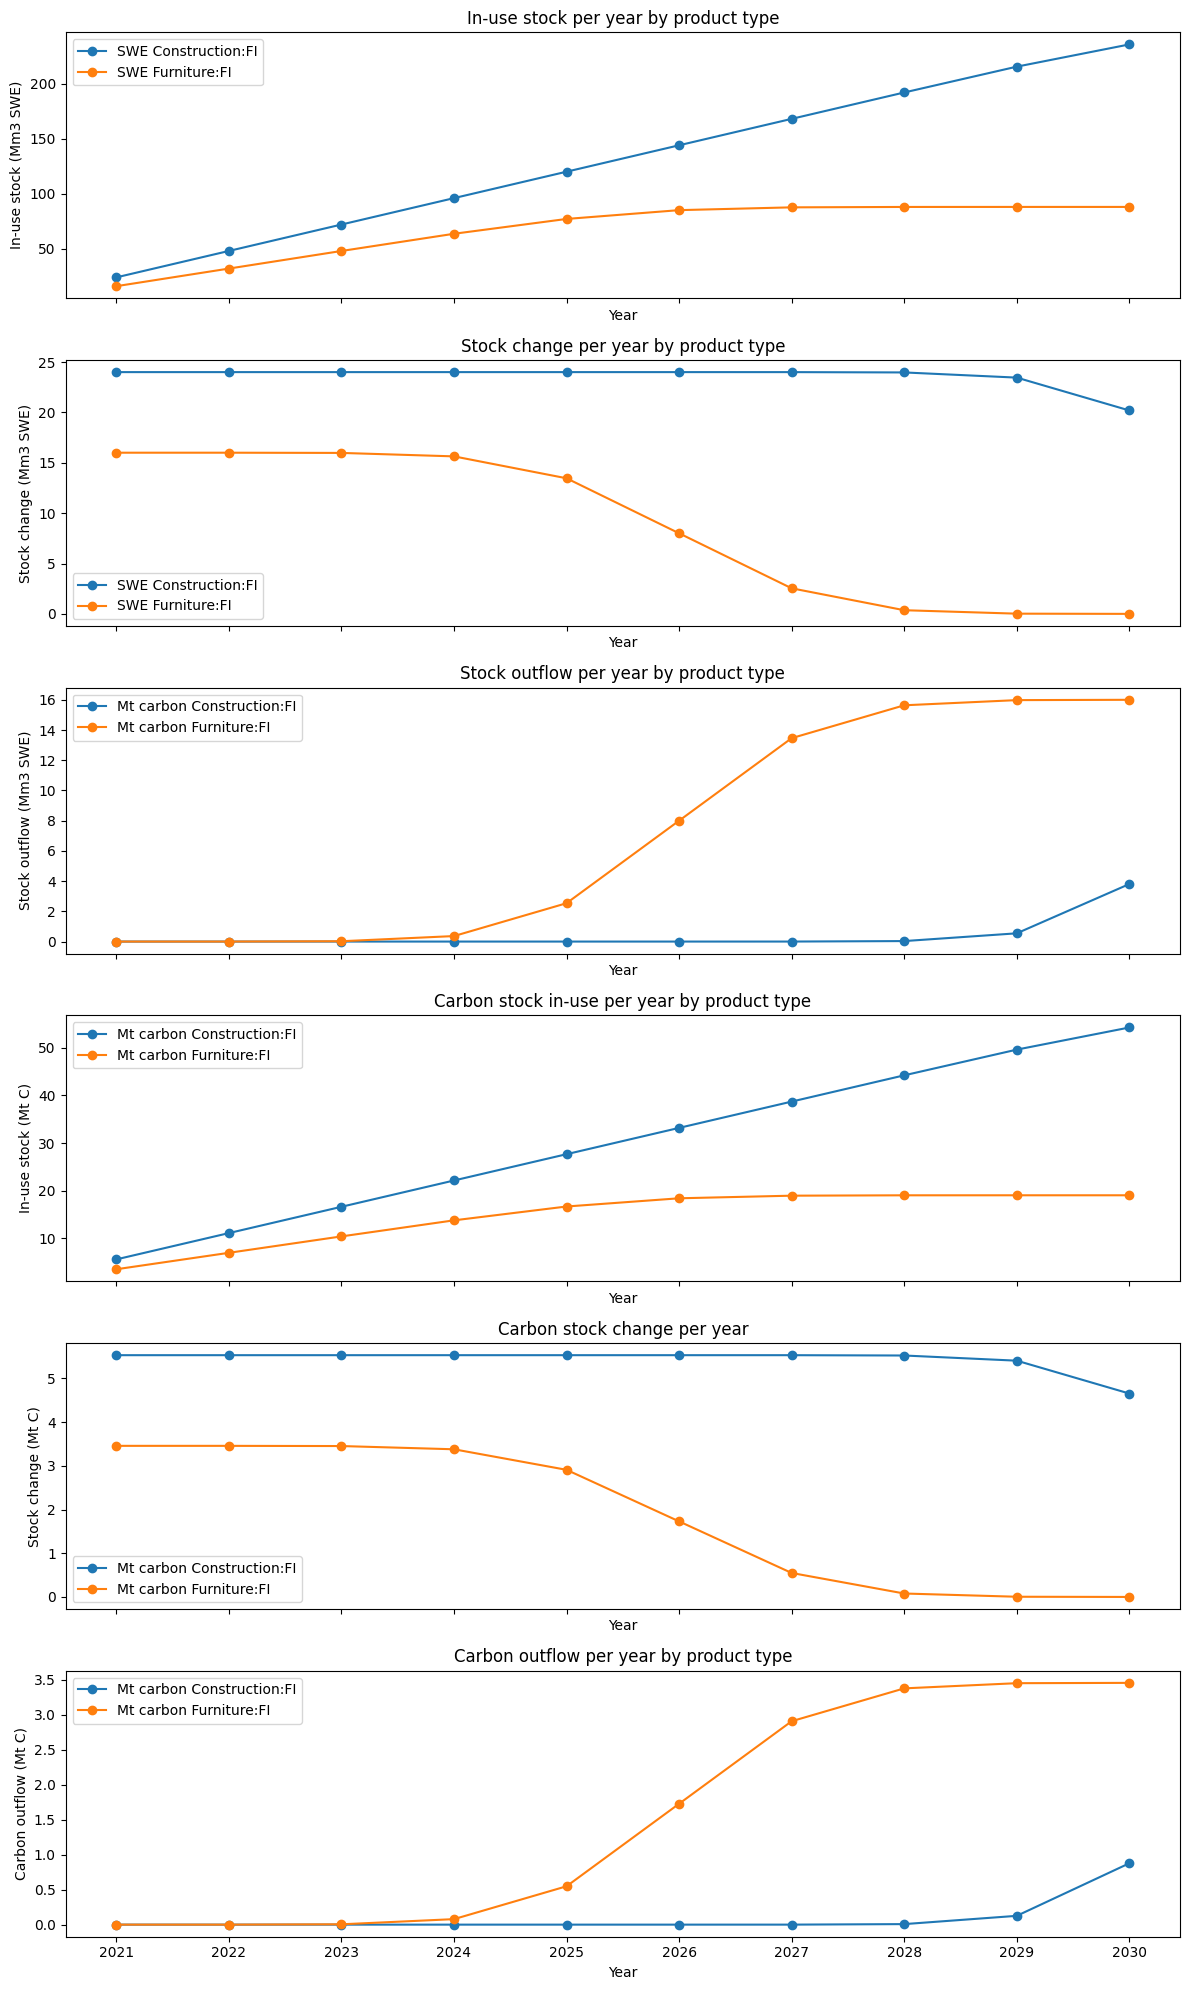

In [5]:
# *****************************************************
# * Step 8: Plot the dynamic stocks results *
# *****************************************************
fig, axes = plt.subplots(6, 1, sharex='all', sharey='none', figsize=(12, 20))

# stock_id_to_dsm_swe and stock_id_to_dsm_carbon are dictionaries containing DynamicStockModel instances
stock_id_to_dsm_swe = flowsolver.get_dynamic_stocks_swe()
stock_id_to_dsm_carbon = flowsolver.get_dynamic_stocks_carbon()
for stock_id in stock_id_to_dsm_swe.keys():
    # SWE Stock
    dsm_swe = stock_id_to_dsm_swe[stock_id]
    swe_stock_by_cohort = dsm_swe.compute_s_c_inflow_driven()
    swe_oc = dsm_swe.compute_o_c_from_s_c()
    swe_stock_total = dsm_swe.compute_stock_total()
    swe_stock_change = dsm_swe.compute_stock_change()
    swe_o = dsm_swe.compute_outflow_total()

    # Carbon stock
    dsm_carbon = stock_id_to_dsm_carbon[stock_id]
    carbon_stock_by_cohort = dsm_carbon.compute_s_c_inflow_driven()
    carbon_oc = dsm_carbon.compute_o_c_from_s_c()
    carbon_stock_total = dsm_carbon.compute_stock_total()
    carbon_stock_change = dsm_carbon.compute_stock_change()
    carbon_o = dsm_carbon.compute_outflow_total()

    # Plot SWE stock total (in-use stocks)
    axes[0].plot(years, swe_stock_total, marker='o', label=f'SWE {stock_id}')
    axes[0].set_ylabel("In-use stock (Mm3 SWE)")
    axes[0].set_title("In-use stock per year by product type")

    # Plot SWE stock change
    axes[1].plot(years, swe_stock_change, marker='o', label=f'SWE {stock_id}')
    axes[1].set_ylabel("Stock change (Mm3 SWE)")
    axes[1].set_title("Stock change per year by product type")

    # Plot SWE outflow by cohort
    axes[2].plot(years, swe_o, marker='o', label=f'Mt carbon {stock_id}')
    axes[2].set_ylabel("Stock outflow (Mm3 SWE)")
    axes[2].set_title("Stock outflow per year by product type")

    # Plot Carbon stock total (in-use stocks)
    axes[3].plot(years, carbon_stock_total, marker='o', label=f'Mt carbon {stock_id}')
    axes[3].set_ylabel("In-use stock (Mt C)")
    axes[3].set_title("Carbon stock in-use per year by product type")

    # Plot Carbon stock change
    axes[4].plot(years, carbon_stock_change, marker='o', label=f'Mt carbon {stock_id}')
    axes[4].set_ylabel("Stock change (Mt C)")
    axes[4].set_title("Carbon stock change per year")

    # Plot carbon outflow by cohort
    axes[5].plot(years, carbon_o, marker='o', label=f'Mt carbon {stock_id}')
    axes[5].set_ylabel("Carbon outflow (Mt C)")
    axes[5].set_title("Carbon outflow per year by product type")

# Set common properties to axes
range_x_ticks = range(min(years), max(years) + 1)
for axis in axes:
    axis.set_xlabel("Year")
    axis.set_xticks(range_x_ticks)
    axis.title.set_size(12)
    axis.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the figure as an SVG file
svg_file_path = "data/stock_plots_by_product.svg"
plt.savefig(svg_file_path, format='svg')

plt.show()

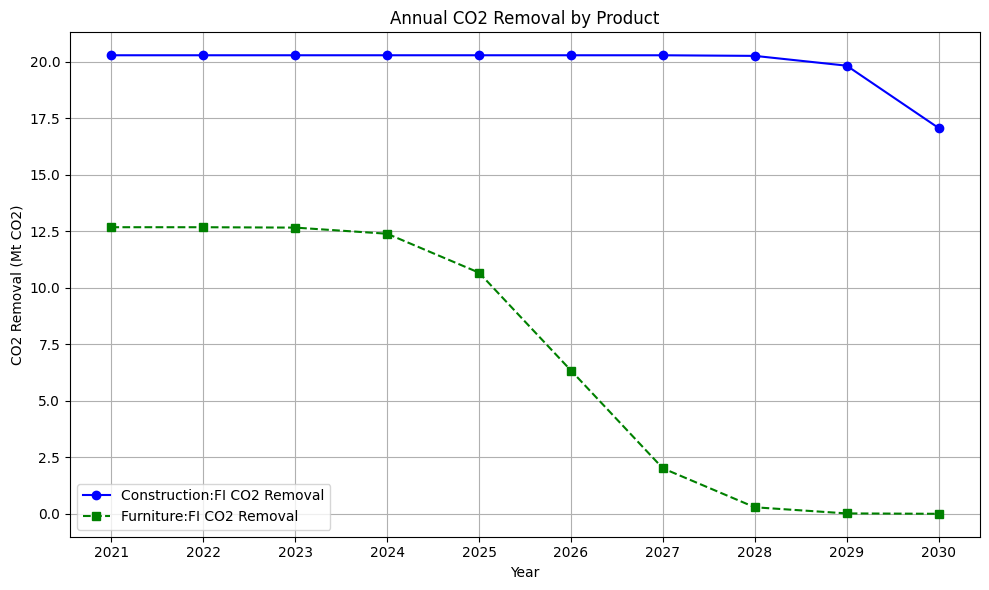

   Year  Construction:FI CO2 Removal (Mt)  Furniture:FI CO2 Removal (Mt)
0  2021                         20.293632                      12.683516
1  2022                         20.293632                      12.683118
2  2023                         20.293632                      12.666399
3  2024                         20.293632                      12.394968
4  2025                         20.293632                      10.671213
5  2026                         20.293626                       6.341760
6  2027                         20.292989                       2.012307
7  2028                         20.266238                       0.288552
8  2029                         19.831949                       0.017121
9  2030                         17.073941                       0.000402


In [6]:
# *****************************************************
# * Step 9: Convert the carbon stocks to CO2 removals *
# *****************************************************
year_start = min(flowsolver_data["years"])
years = flowsolver_data["years"]

# Calculate annual CO2 removal for each stock
results_co2_removals = pd.DataFrame({'Year': years})
stock_id_to_dsm_carbon = flowsolver.get_dynamic_stocks_carbon()
for stock_id, dsm_carbon in stock_id_to_dsm_carbon.items():
    total_inflows_carbon = dsm_carbon.i
    total_outflows_carbon = dsm_carbon.o
    annual_co2_removal = (total_inflows_carbon - total_outflows_carbon) * model_params["conversion_factor_c_to_co2"]
    results_co2_removals[f'{stock_id} CO2 Removal (Mt)'] = annual_co2_removal

# Plot each product's CO2 removal
plt.figure(figsize=(10, 6))

# Define line styles, markers, and colors for differentiation
line_styles = ['-', '--', '-.', ':']
markers = ['o', 's', '^', 'D']
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

for idx, stock_id in enumerate(stock_id_to_dsm_carbon.keys()):
    line_style = line_styles[idx % len(line_styles)]
    marker = markers[idx % len(markers)]
    color = colors[idx % len(colors)]

    if f'{stock_id} CO2 Removal (Mt)' in results_co2_removals.columns:
        plt.plot(results_co2_removals['Year'], results_co2_removals[f'{stock_id} CO2 Removal (Mt)'], marker=marker, linestyle=line_style, color=color, label=f'{stock_id} CO2 Removal')

plt.xlabel('Year')
plt.ylabel('CO2 Removal (Mt CO2)')
plt.title('Annual CO2 Removal by Product')
plt.grid(True)
plt.xticks(years)
plt.legend()
plt.tight_layout()

# Save the figure as an SVG file
svg_file_path = "data/annual_co2_removal_by_product.svg"
plt.savefig(svg_file_path, format='svg')

plt.show()
print(results_co2_removals)

In [7]:
# *****************************************************
# * Step 10: Visualize the flow graph as Sankey graph *
# *****************************************************

# Color mappings
process_transformation_stage_colors = dict()
process_transformation_stage_colors["Source"] = "#7DDA60"
process_transformation_stage_colors["First"] = "#eb5e34"
process_transformation_stage_colors["Second"] = "#8c76cf"
process_transformation_stage_colors["Third"] = "#5BAA11"
process_transformation_stage_colors["VAM"] = "#3281db"
process_transformation_stage_colors["RoW"] = "#61b053"  # Rest of the world
process_transformation_stage_colors["EoL"] = "#EFC3CA"  # Brown
process_transformation_stage_colors["by_prod"] = "#DFC57B"  # gold
process_transformation_stage_colors["Virtual"] = "#707070"

# Label overrides
virtual_process_graph_labels = dict()
virtual_process_graph_labels["VP_P2:EU"] = "Unreported flow from P2"
virtual_process_graph_labels["VP_P3:EU"] = "Unreported flow from P3"

# Virtual Process and virtual Flow colors
visualizer_params = {
    # User can hide processes in Sankey graph that have total inflows less than this value
    # This value cannot be changed now in the Sankey graph
    "small_node_threshold": 5,

    # Dictionary to define labels for virtual flows
    # If dictionary contains label for the virtual process then that is used,
    # otherwise the virtual process ID is used
    "virtual_process_graph_labels": virtual_process_graph_labels,

    # Dictionary to define color of process by the process transformation stage name
    # All must be provided as a RGB hex string, prefixed by character '#'
    # Usage example: { "Source": "#707070" }
    "process_transformation_stage_colors": process_transformation_stage_colors,

    # How transparent flows are (0.0 = invisible, 1.0 = fully opaque)
    "flow_alpha": 0.75,

    # Color for virtual process
    "virtual_process_color": "rgba(0.3, 0.3, 0.3, 0.6)",

    # Color for virtual flows
    "virtual_flow_color": "rgba(0.5, 0.5, 0.5, 0.5)",
}

visualizer = DataVisualizer()
visualizer.build(flowsolver, visualizer_params)
visualizer.show()